In [22]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from os.path import join as oj
import os
import pygsheets
import pandas as pd
import sys
import inspect
from datetime import datetime, timedelta
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)
sys.path.append(parentdir + '/modeling')
import load_data
from fit_and_predict import fit_and_predict_ensemble
from functions import merge_data
from viz import viz_interactive, viz_static
import matplotlib.pyplot as plt
import plotly.express as px
import plotly
from functions import merge_data
from fit_and_predict import add_preds
from update_severity_index import df_to_plot, add_severity_index

NUM_DAYS_LIST = [1, 2, 3, 4, 5, 6, 7]
cs = ['#6E8E96', '#D3787D', '#AC3931']
df_hospital = load_data.load_hospital_level(data_dir=oj(os.path.dirname(parentdir), 'covid-19-private-data'))
df_county = load_data.load_county_level(data_dir=oj(parentdir, 'data'))
df_county = add_preds(df_county, NUM_DAYS_LIST=NUM_DAYS_LIST, cached_dir=oj(parentdir, 'data')) # adds keys like "Predicted Deaths 1-day"
df = merge_data.merge_county_and_hosp(df_county, df_hospital)
df = add_severity_index(df, NUM_DAYS_LIST)
df = df.sort_values('Total Deaths Hospital', ascending=False)
d = df_to_plot(df, NUM_DAYS_LIST)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
loaded and merged COVID-19 cases/deaths data successfully


# county-level plot

In [ ]:
num_days_in_past = 3
output_key = f'Predicted Deaths {num_days_in_past}-day'   

today = datetime.today().strftime("%B %d")
plt.figure(dpi=500)
day_past = (datetime.now() - timedelta(days=3)).strftime("%B %d")
plt.plot([0, max(df_county[output_key])], [0, max(df_county[output_key])], 
         '--', color='gray')
plt.plot(df_county['tot_deaths'], 
         df_county[output_key], '.')

plt.xlabel(f'Actual deaths by {today}')
plt.ylabel(f'Predicted deaths by {today}\n(predicted on {day_past})')
plt.xscale('log')
plt.yscale('log')
plt.show()

# hospital-level plot

In [11]:
def plot_scatter(x, y, c, s, xlab, ylab, colorlab, sizelab, markersize_rescaling):
    fig, ax = plt.subplots(dpi=500, figsize=(7, 3))
    scatter = ax.scatter(x, y, c=c, s=s, alpha=1)
    plt.yscale('symlog')
    plt.xscale('symlog')

    # produce a legend with the unique colors from the scatter
    leg_els = [Line2D([0], [0], marker='o', color='w', label='High', markerfacecolor=cs[2], markersize=6),
               Line2D([0], [0], marker='o', color='w', label='Medium', markerfacecolor=cs[1], markersize=6),
               Line2D([0], [0], marker='o', color='w', label='Low', markerfacecolor=cs[0], markersize=6)]

    # leg_els = scatter.legend_elements()
    # legend1 = ax.legend(*leg_els, loc="upper left", title="Severity Index")
    legend1 = ax.legend(handles=leg_els, loc="upper left", title=colorlab, fontsize=9)
    ax.add_artist(legend1)

    # produce a legend with a cross section of sizes from the scatter
    handles, labels = scatter.legend_elements(prop="sizes", alpha=1)
    l2 = []
    for i in range(len(labels)):
        s = labels[i]
        num = markersize_rescaling * int(s[s.index('{') + 1: s.index('}')])
        l2.append('$\\mathdefault{' + str(num) + '}$')
    legend2 = ax.legend(handles, l2, loc="lower right", title=sizelab)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.show()

In [12]:
# viz_interactive.viz_index_animated(d, [1, 3, 5],
#                                    out_name=oj(parentdir, 'results', 'hospital_index_animated.html'))    

In [ ]:
today = datetime.today().strftime("%B %d")
plt.figure(dpi=500, figsize=(7, 3))
remap = {1: 'Low', 2: 'Medium', 3: 'High'}
# cs = ['b','#dec34b','r']

# cs = ['#91bfdb','#dec34b','#fc8d59']
for i in [3, 2, 1]:
    dr = d[d['Severity 3-day']==i]
    plt.plot(dr['Total Deaths Hospital'], 
             dr['Predicted New Deaths Hospital 3-day'], '.',
             label=f'{remap[i]}', alpha=1, color=cs[i -1])
plt.xlabel(f'Total deaths at hospital by {today}')
plt.ylabel('Predicted new deaths at hospital in\nnext 3 days')
plt.xscale('log')
plt.yscale('log')
plt.legend(title='Severity Index')
plt.show()

In [ ]:
today = datetime.today().strftime("%B %d")
remap = {1: 'Low', 2: 'Medium', 3: 'High'}
cs_d = {i: cs[i-1] for i in [1, 2, 3]}
# cs = ['#91bfdb','#dec34b','#fc8d59']
markersize_rescaling = 10
x = d['Total Deaths Hospital']
y = d['Surge 3-day']
c = [cs_d[x] for x in d['Severity 3-day']] # d['Severity 3-day'] #
s = d['ICU Beds'] / markersize_rescaling
xlab = f'Total deaths at hospital by {today}'
ylab = 'Surge Index 3-day'
colorlab = 'Severity Index'
sizelab = '#ICU beds'

viz_static.plot_scatter(x, y, c, s, xlab, ylab, colorlab, sizelab, markersize_rescaling)

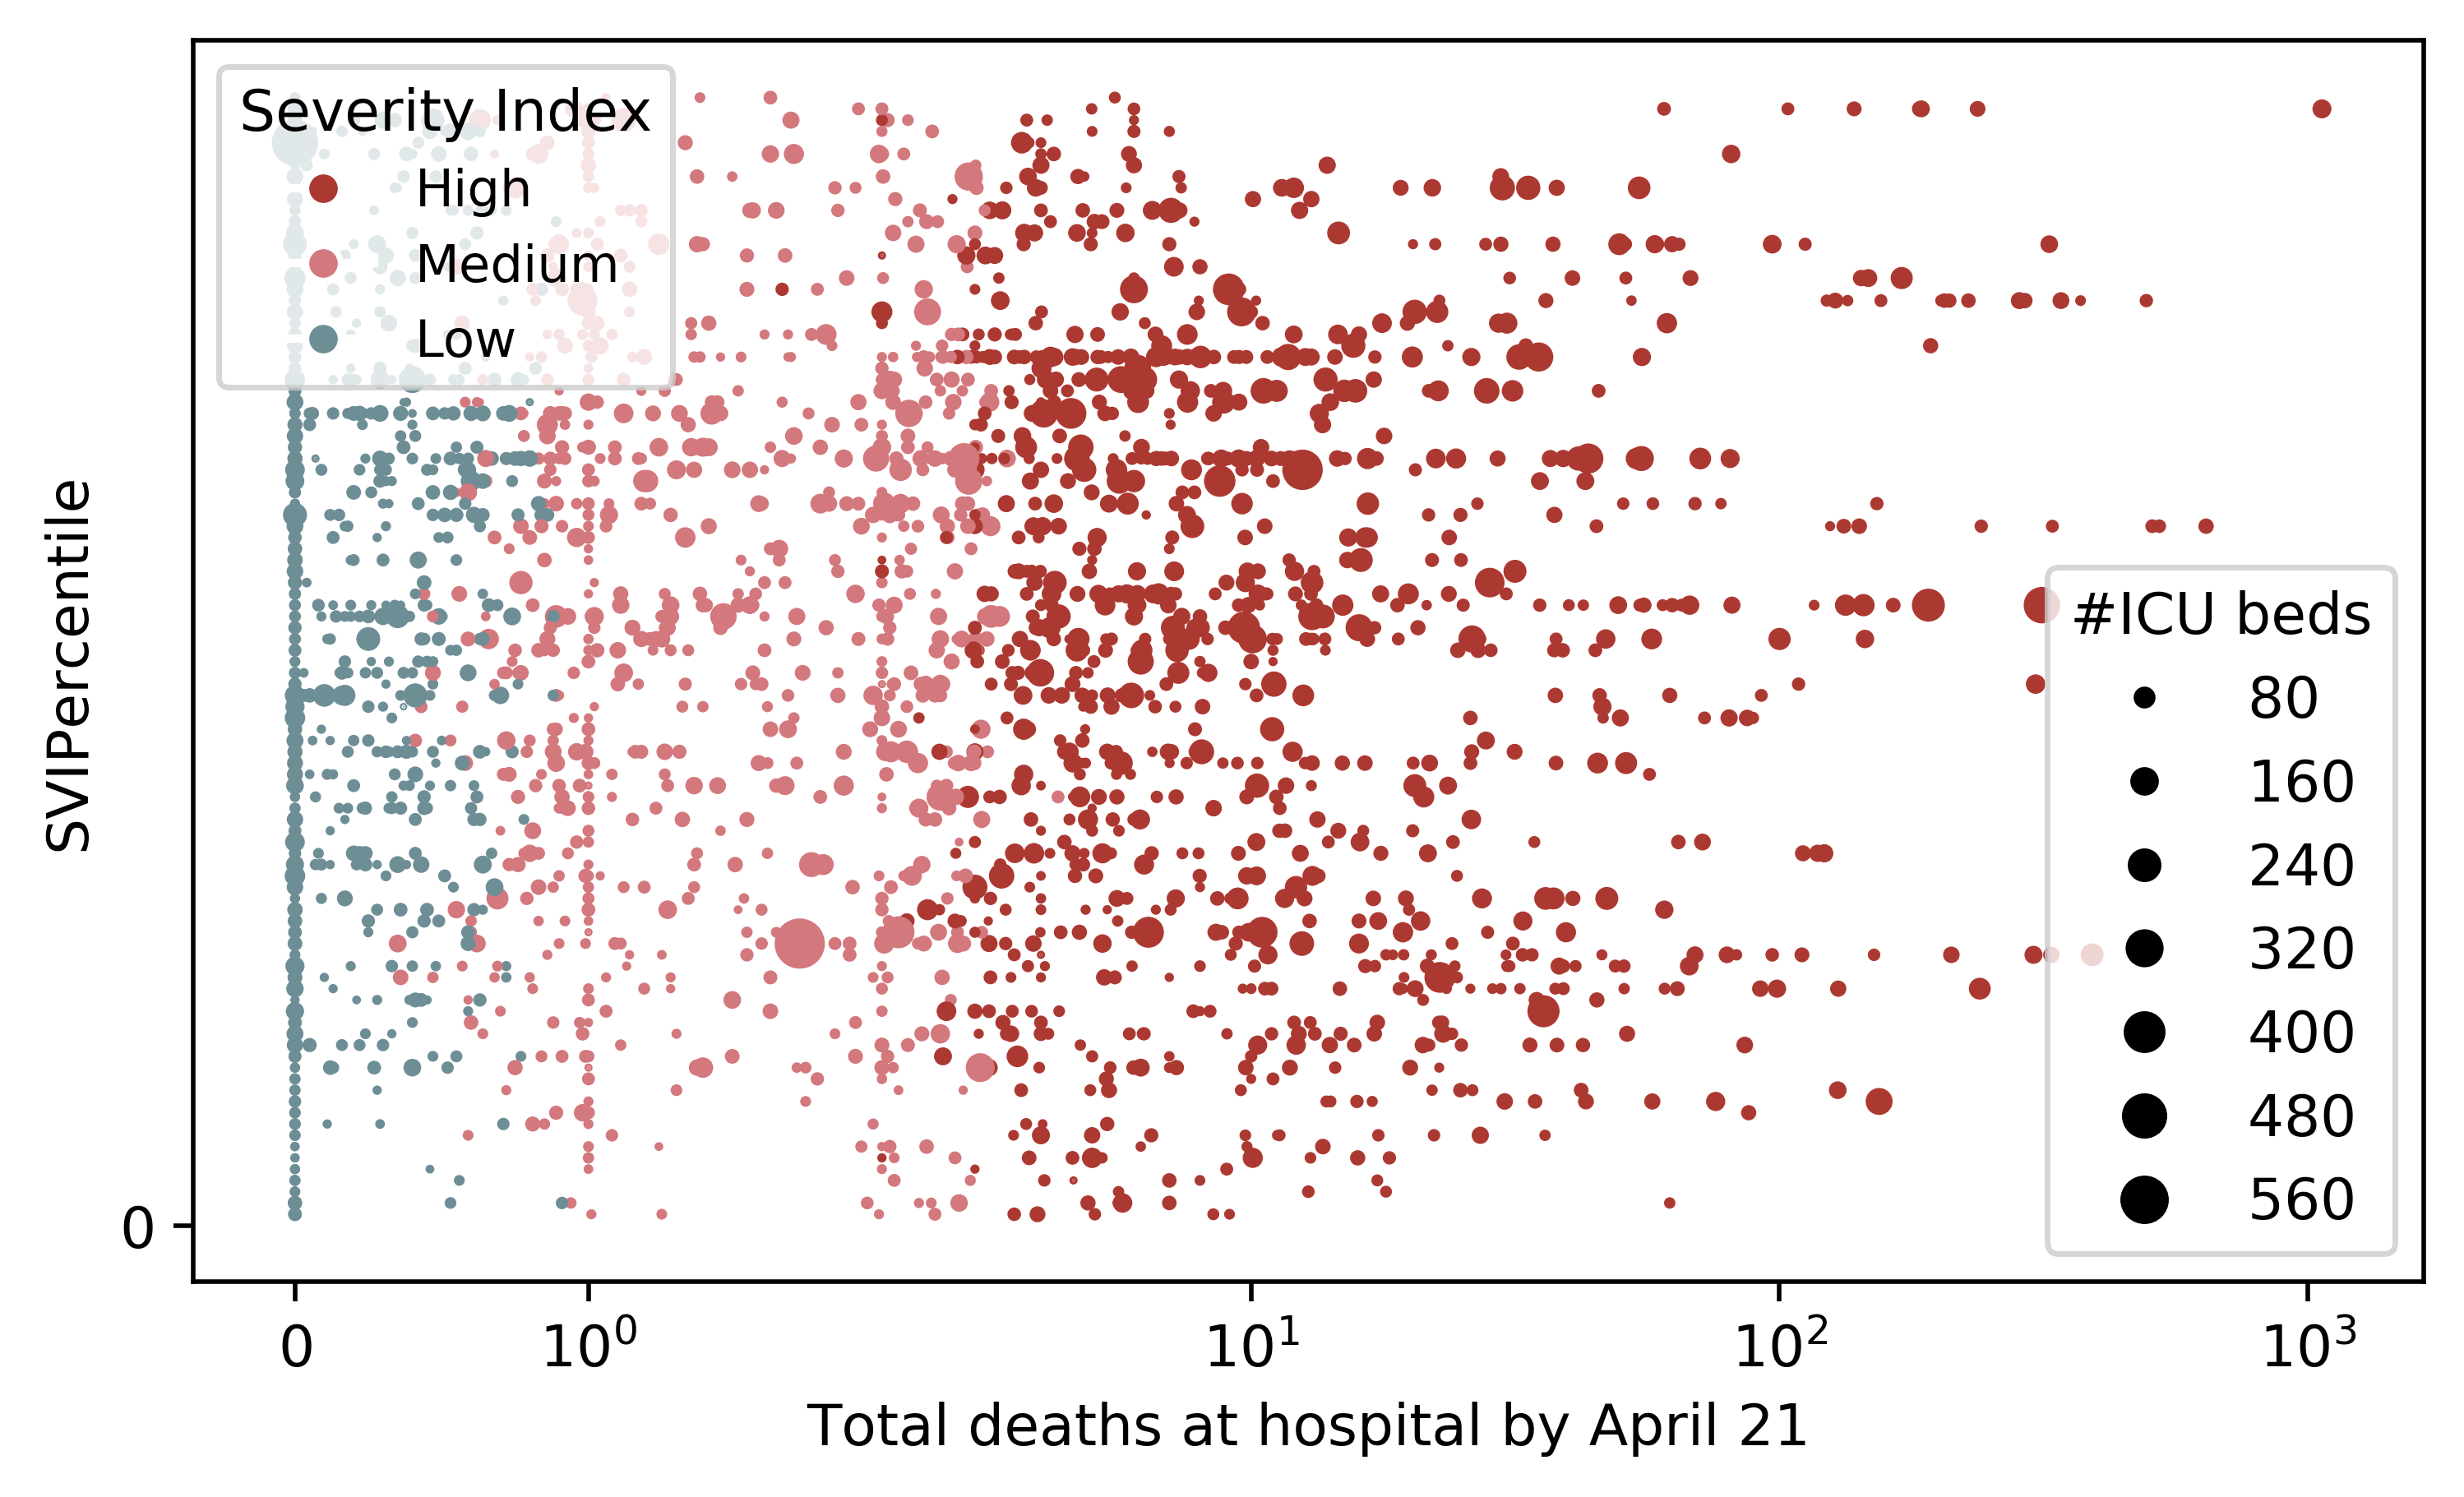

In [32]:
today = datetime.today().strftime("%B %d")
remap = {1: 'Low', 2: 'Medium', 3: 'High'}
cs_d = {i: cs[i-1] for i in [1, 2, 3]}
# cs = ['#91bfdb','#dec34b','#fc8d59']
markersize_rescaling = 10
x = d['Total Deaths Hospital']
y = d['SVIPercentile']
c = [cs_d[x] for x in d['Severity 3-day']] # d['Severity 3-day'] #
s = d['ICU Beds'] / markersize_rescaling
xlab = f'Total deaths at hospital by {today}'
ylab = 'SVIPercentile'
colorlab = 'Severity Index'
sizelab = '#ICU beds'

viz_static.plot_scatter(x, y, c, s, xlab, ylab, colorlab,
                        sizelab, markersize_rescaling, figsize=(7, 4))

In [ ]:
today = datetime.today().strftime("%B %d")
plt.figure(dpi=500, figsize=(7, 3))
remap = {1: 'Low', 2: 'Medium', 3: 'High'}
x = 'Total Deaths Hospital'
y = 'Surge 3-day'

for i in [3, 2, 1]:
    dr = d[d['Severity 3-day']==i]
    plt.plot(dr[x], dr[y], '.',
             label=f'{remap[i]}', alpha=0.3, color=cs[i -1])

# plt.scatter(d[x], d[y], c=d['Severity 3-day'])
plt.xlabel(f'Total deaths at hospital by {today}')
plt.ylabel('Surge Index 3-day')
# plt.xscale('log')
# plt.yscale('log')
plt.yscale('symlog')
plt.xscale('symlog')
plt.legend(title='Severity Index')
plt.show()